In [146]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

## Cleaning and setting the data up

In [147]:
csv_path: str = "./BTCUSDT-D.csv"
price_data = pd.read_csv(csv_path)

#### Add days and months from date col

In [148]:
dates = price_data.date
day_list = []
month_list = []

for row in dates:
    day = row.split("-")[0]
    month = row.split("-")[2]

    day_list.append(day)
    month_list.append(month)

price_data["day"] = day_list
price_data["month"] = month_list

In [149]:
price_data = price_data.drop(["date", "time", "volume"], axis=1)

#### Create label targets

In [150]:
price_open = price_data.open
price_close = price_data.close

In [151]:
target = []

for row in range(len(price_open)):
    
    if price_close[row] - price_open[row] > 0:
        target.append("long")
    else:
        target.append("short")

price_data["target"] = target

#### Daily change (Feature)

In [152]:
daily_change = [0]

for row in range(len(price_open)):

    if row == 0:
        continue

    change = (price_open[row] - price_open[row-1]) / price_open[row - 1] * 100
    daily_change.append(round(change,2))

price_data["daily_change"] = daily_change

#### Encoding

In [153]:
day_encoder = LabelEncoder()
month_encoder = LabelEncoder()
target_encoder = LabelEncoder()

day = day_encoder.fit_transform(price_data.day)
price_data["day"] = day

month = month_encoder.fit_transform(price_data.month)
price_data["month"] = month

target = target_encoder.fit_transform(price_data.target)
price_data["target"] = target

In [154]:
X = price_data.filter(["day", "month", "daily_change", "target"])

X_train_full, X_test, y_train_full, y_test = train_test_split(X.drop("target", axis=1), X.target, random_state = 42)

X_val, X_train = X_train_full[:100], X_train_full[100:]
y_val, y_train = y_train_full[:100], y_train_full[100:]

# Get the number of features in the dataset by isolating the second number in "shape", this is needed to feed into the
# NN inputlayer
input_shape = X_train_full.shape[1]

#### NN model

In [155]:
model = keras.models.Sequential([
              keras.layers.InputLayer(shape=(input_shape,)),
              keras.layers.Dense(300, activation="relu"),
              keras.layers.Dense(100, activation="relu"),
              keras.layers.Dense(2, activation="softmax")
          ])

In [156]:
# model.compile(loss="binary_crossentropy",
#              optimizer=keras.optimizers.SGD(learning_rate=0.001),
#              metrics=["accuracy"])

model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

#### Training

In [157]:
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5188 - loss: 0.7046 - val_accuracy: 0.5600 - val_loss: 0.6853
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5666 - loss: 0.6837 - val_accuracy: 0.5500 - val_loss: 0.6894
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5397 - loss: 0.6968 - val_accuracy: 0.5900 - val_loss: 0.6803
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5455 - loss: 0.6848 - val_accuracy: 0.5500 - val_loss: 0.6871
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5529 - loss: 0.6897 - val_accuracy: 0.5700 - val_loss: 0.6859
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5769 - loss: 0.6763 - val_accuracy: 0.5400 - val_loss: 0.6892
Epoch 7/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5285 - loss: 0.6889 - val_accuracy: 0.5500 - val_loss: 0.6896
Epoch 8/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5522 - loss: 0.6821 - val_accuracy: 0.5500 - 

#### Visualization

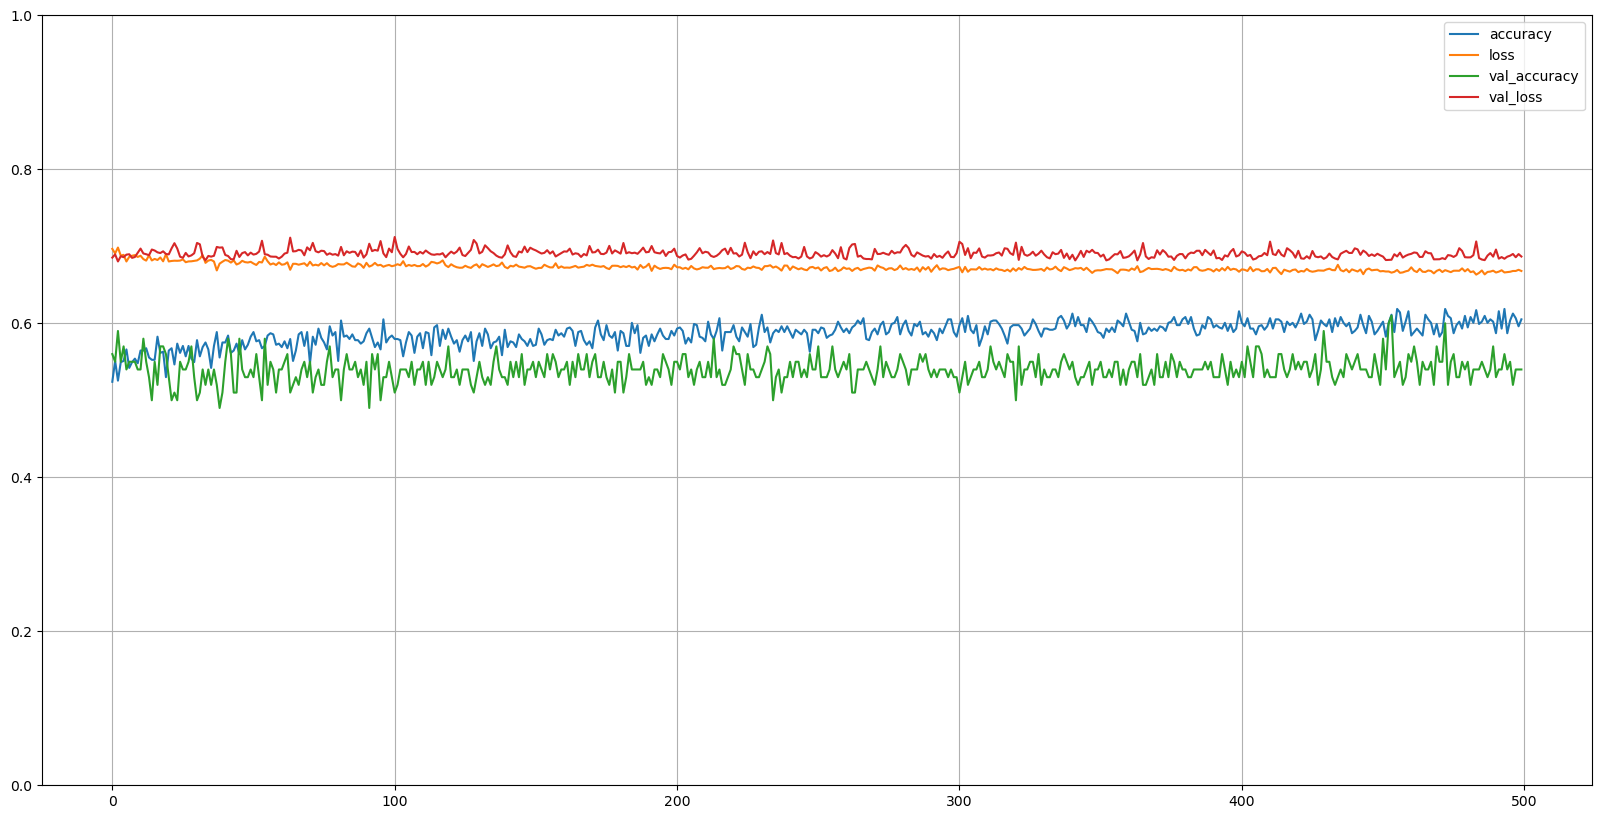

In [158]:
pd.DataFrame(history.history).plot(figsize=(20, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### Testing

In [159]:
model.evaluate(X_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5100 - loss: 0.6986


[0.6990848779678345, 0.52734375]

In [160]:
X_new = X_test[:5]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


array([[0.35, 0.65],
       [0.44, 0.56],
       [0.56, 0.44],
       [0.72, 0.28],
       [0.38, 0.62]], dtype=float32)

In [161]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([1, 1, 0, 0, 1], dtype=int64)

In [162]:
y_new = y_test[:5]
y_new

992    0
478    1
689    1
31     0
617    1
Name: target, dtype: int32